In [2]:
import pandas as pd

df = pd.read_csv("tobacco_data_clean.csv")

binary_cols = [
    "sex",
    "hhnum",
    "vt",
    "esr",
    "inddea",
    "smok100"
]

categorical_cols = [
    "stater",
    "pob",
    "race",
    "hisp",
    "ms",
    "tenure",
    "educ",
    "citizen",
    "majocc",
    "histatus",
    "smokstat",
    "everuse"
]

continuous_cols = [
    "age",
    "povpct"
]

for col in binary_cols:
    df[col] = df[col].astype(int)

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

dummy_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in categorical_cols)]

for col in dummy_cols:
    df_encoded[col] = df_encoded[col].astype(int)

df_encoded.to_csv("tobacco_data_model.csv", index=False)


Training positives = 16124, negatives = 378501
scale_pos_weight = 23.47

--- Fold 1 ---
Accuracy          : 0.8293
Balanced Accuracy : 0.8348
Precision         : 0.1730
Recall            : 0.8409
F1-score          : 0.2870
ROC-AUC           : 0.9054
PR-AUC            : 0.3353

--- Fold 2 ---
Accuracy          : 0.8321
Balanced Accuracy : 0.8381
Precision         : 0.1760
Recall            : 0.8447
F1-score          : 0.2913
ROC-AUC           : 0.9114
PR-AUC            : 0.3553

--- Fold 3 ---
Accuracy          : 0.8310
Balanced Accuracy : 0.8356
Precision         : 0.1745
Recall            : 0.8406
F1-score          : 0.2890
ROC-AUC           : 0.9101
PR-AUC            : 0.3556

--- Fold 4 ---
Accuracy          : 0.8322
Balanced Accuracy : 0.8367
Precision         : 0.1757
Recall            : 0.8416
F1-score          : 0.2907
ROC-AUC           : 0.9071
PR-AUC            : 0.3615

--- Fold 5 ---
Accuracy          : 0.8297
Balanced Accuracy : 0.8352
Precision         : 0.1735
Recall     

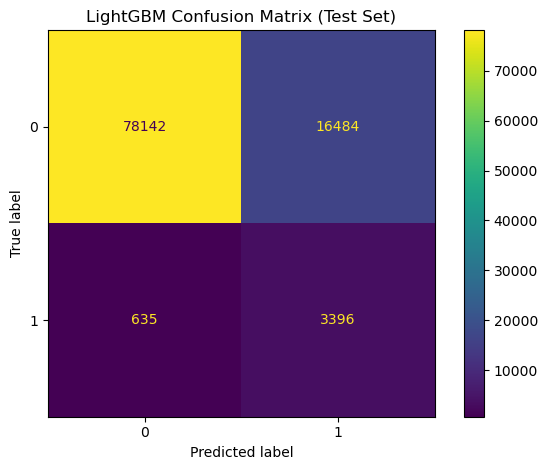

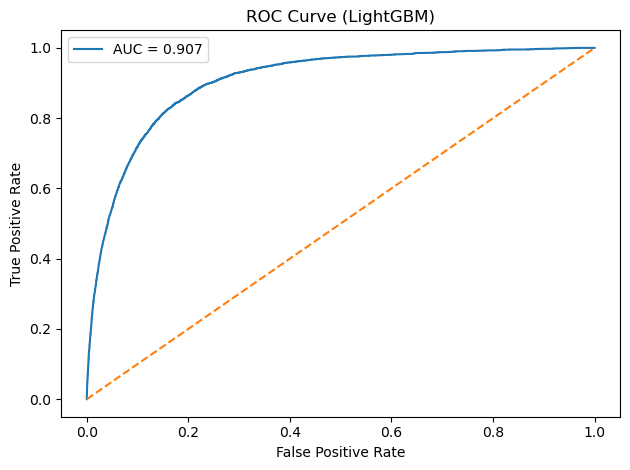

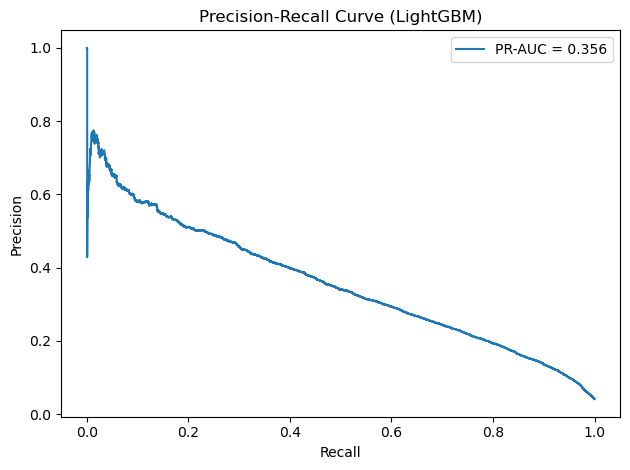

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve
)

import lightgbm as lgb

# =================================================
# STEP-BY-STEP DESCRIPTION:
# 1) Load the model-ready (one-hot encoded) dataset from CSV.
# 2) Split into features (X) and target (y = inddea), then create a stratified train/test split.
# 3) Measure class imbalance in the training set and compute scale_pos_weight to up-weight the minority class.
# 4) Run 5-fold stratified cross-validation on the training set and print fold-wise metrics + a summary.
# 5) Fit a final LightGBM model on the full training set (with class weighting).
# 6) Evaluate final performance on the held-out test set and print the key metrics.
# 7) Visualize test-set performance using: Confusion Matrix, ROC curve, Precision-Recall curve.
# 8) Provide a helper function to make a single-row prediction from a dictionary of input features.
# =================================================

# 1) Load data
data_path = "tobacco_data_model_ready.csv"
df = pd.read_csv(data_path)

TARGET_COL = "inddea"
y = df[TARGET_COL].values
X = df.drop(columns=[TARGET_COL])
feature_names = X.columns.tolist()

# 2) Train-test split (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3) Class imbalance handling (compute class weight ratio from TRAIN only)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos

print(f"Training positives = {pos}, negatives = {neg}")
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

# 4) LightGBM parameters
lgb_params = {
    "n_estimators": 400,
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "binary",
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
    "verbose": -1
}

# 5) Stratified K-Fold Cross-Validation on the training split
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = {
    "accuracy": [], "balanced_accuracy": [],
    "precision": [], "recall": [], "f1": [],
    "roc_auc": [], "pr_auc": []
}

fold = 1
for tr_idx, val_idx in kfold.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    model = lgb.LGBMClassifier(**lgb_params)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc"
    )

    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)

    cv_metrics["accuracy"].append(accuracy_score(y_val, y_val_pred))
    cv_metrics["balanced_accuracy"].append(balanced_accuracy_score(y_val, y_val_pred))
    cv_metrics["precision"].append(precision_score(y_val, y_val_pred, zero_division=0))
    cv_metrics["recall"].append(recall_score(y_val, y_val_pred, zero_division=0))
    cv_metrics["f1"].append(f1_score(y_val, y_val_pred, zero_division=0))
    cv_metrics["roc_auc"].append(roc_auc_score(y_val, y_val_proba))
    cv_metrics["pr_auc"].append(average_precision_score(y_val, y_val_proba))

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy          : {cv_metrics['accuracy'][-1]:.4f}")
    print(f"Balanced Accuracy : {cv_metrics['balanced_accuracy'][-1]:.4f}")
    print(f"Precision         : {cv_metrics['precision'][-1]:.4f}")
    print(f"Recall            : {cv_metrics['recall'][-1]:.4f}")
    print(f"F1-score          : {cv_metrics['f1'][-1]:.4f}")
    print(f"ROC-AUC           : {cv_metrics['roc_auc'][-1]:.4f}")
    print(f"PR-AUC            : {cv_metrics['pr_auc'][-1]:.4f}")
    fold += 1

print("\n===== CV SUMMARY =====")
for k, v in cv_metrics.items():
    print(f"{k:18s}: {np.mean(v):.4f} ± {np.std(v):.4f}")

# 6) Train final model on full training data
final_model = lgb.LGBMClassifier(**lgb_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc"
)

# 7) Test performance
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_acc = accuracy_score(y_test, y_test_pred)
test_bal = balanced_accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_roc = roc_auc_score(y_test, y_test_proba)
test_pr = average_precision_score(y_test, y_test_proba)

print("\n===== TEST SET RESULTS (LightGBM) =====")
print(f"Accuracy          : {test_acc:.4f}")
print(f"Balanced Accuracy : {test_bal:.4f}")
print(f"Precision         : {test_prec:.4f}")
print(f"Recall            : {test_rec:.4f}")
print(f"F1-score          : {test_f1:.4f}")
print(f"ROC-AUC           : {test_roc:.4f}")
print(f"PR-AUC            : {test_pr:.4f}")

# 8) Confusion matrix (test set)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("LightGBM Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# 9) ROC curve (test set)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f"AUC = {test_roc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.tight_layout()
plt.show()

# 10) Precision–Recall curve (test set)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall, precision, label=f"PR-AUC = {test_pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.legend()
plt.tight_layout()
plt.show()

# 11) Prediction helper (dictionary -> aligned row -> predicted probability + class)
def predict_death_lgb(model, person_dict, threshold=0.5):
    row = pd.DataFrame([person_dict])

    for col in feature_names:
        if col not in row:
            row[col] = 0

    row = row[feature_names]

    proba = float(model.predict_proba(row)[0][1])
    pred = int(proba >= threshold)

    status = "would die" if pred == 1 else "would NOT die"

    print("\nPrediction (LightGBM):")
    print(f"Predicted class      : {pred} → {status}")
    print(f"Probability of death : {proba:.4f}")

    return pred, proba


C:\Users\Naman\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Naman\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


LightGBM base value (class 1): -2.0861901021884726


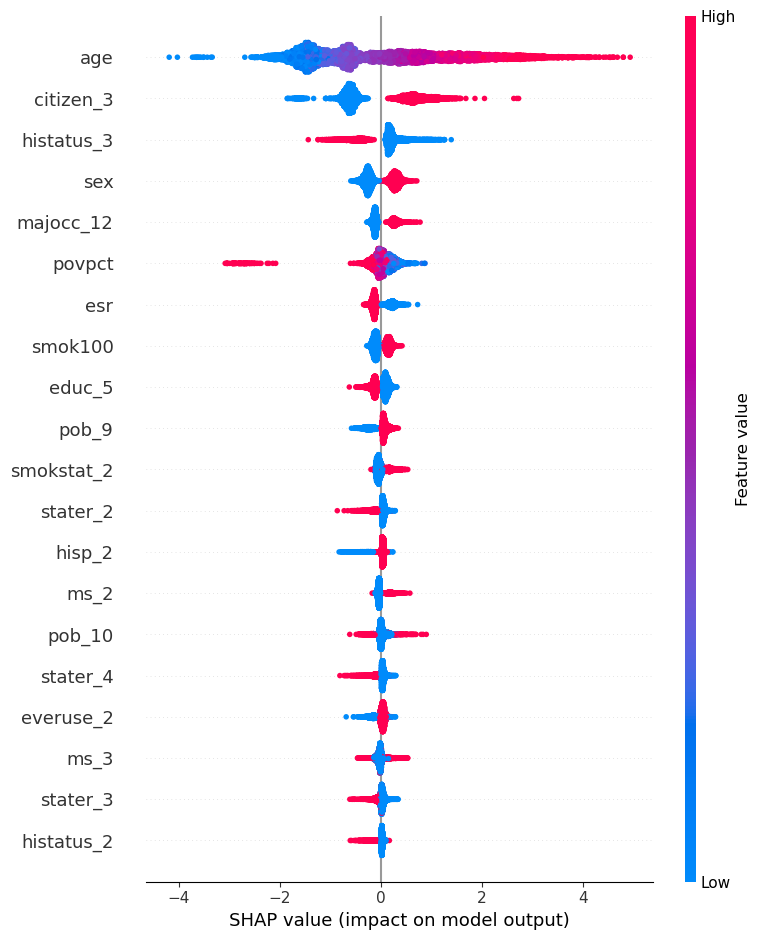

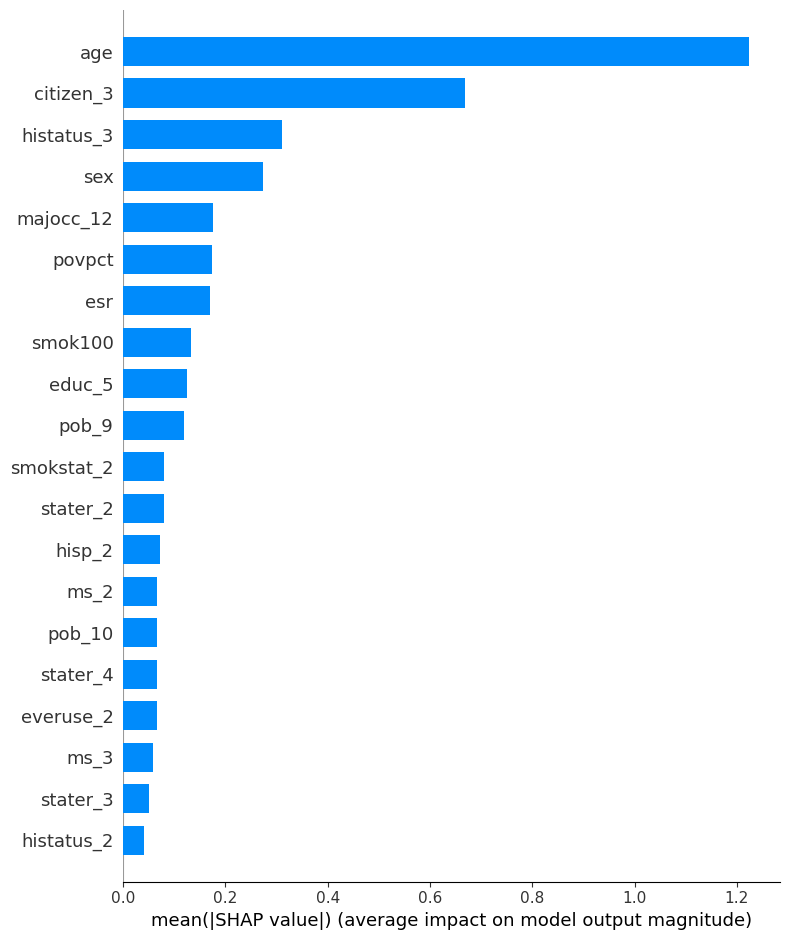

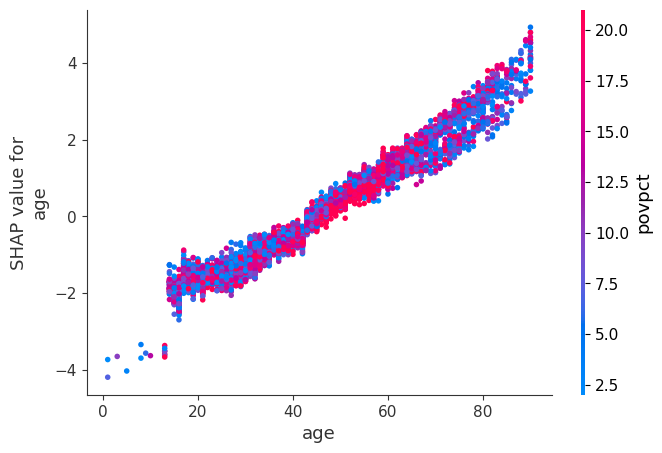

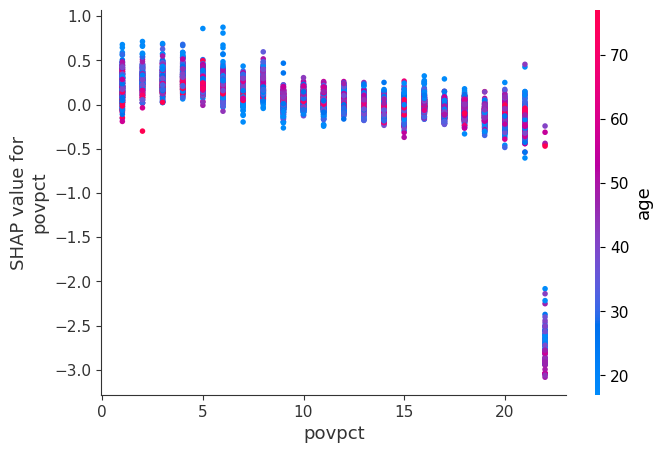

C:\Users\Naman\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


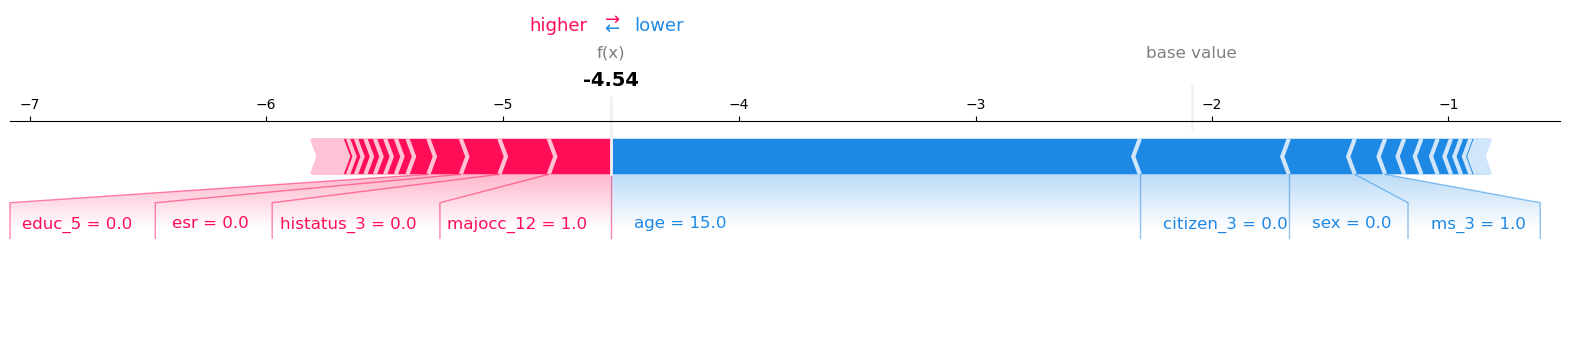

In [7]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# =================================================
# STEP-BY-STEP DESCRIPTION:
# 1) Select a manageable subset of the test data for SHAP to keep computation fast.
# 2) Create a SHAP TreeExplainer for the trained LightGBM model.
# 3) Compute SHAP values and correctly extract the values for the positive class (death = 1).
# 4) Print the base (expected) value used by the SHAP explainer for class 1.
# 5) Visualize global feature importance using:
#    - SHAP summary (beeswarm) plot
#    - SHAP summary bar plot
# 6) Visualize feature interactions using dependence plots for key continuous variables.
# 7) Generate an individual-level explanation for a single observation using a force plot.
# =================================================

n_sample = min(len(X_test), 8000)
X_shap = X_test.sample(n=n_sample, random_state=42)
feature_names = X_shap.columns.tolist()

explainer_lgb = shap.TreeExplainer(final_model)

shap_values = explainer_lgb.shap_values(X_shap)
if isinstance(shap_values, list):
    shap_values_lgb = shap_values[1]
    base_value = explainer_lgb.expected_value[1]
else:
    shap_values_lgb = shap_values
    base_value = explainer_lgb.expected_value

print("LightGBM base value (class 1):", base_value)

shap.summary_plot(
    shap_values_lgb,
    X_shap,
    feature_names=feature_names,
    show=True
)

shap.summary_plot(
    shap_values_lgb,
    X_shap,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

if "age" in feature_names and "povpct" in feature_names:
    shap.dependence_plot(
        "age",
        shap_values_lgb,
        X_shap,
        interaction_index="povpct",
        show=True
    )

if "povpct" in feature_names and "age" in feature_names:
    shap.dependence_plot(
        "povpct",
        shap_values_lgb,
        X_shap,
        interaction_index="age",
        show=True
    )

i = 0
x_person = X_shap.iloc[[i]]
shap_person = explainer_lgb.shap_values(x_person)
if isinstance(shap_person, list):
    shap_person = shap_person[1]

shap.force_plot(
    base_value,
    shap_person,
    x_person,
    matplotlib=True
)
plt.show()
